# Code for downloading rainfall data from NOAA radar

##### Note: Install the rasterio module using the command line, "conda install rasterio"

In [1]:
# Import modules

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio import features as ft

In [2]:
# Obtain the current working directory

glob.os.getcwd()


'C:\\Users\\parkernath32\\Dropbox\\Nathaniel Parker\\KSU_Coursework\\Spring 2020\\Introduction to Scientific Programming\\semester_project'

In [3]:
# User inputs

SOI = input('Enter station name')
lat_SOI = float(input('Enter latitude'))
lon_SOI = float(input('Enter longitude'))
interval = input('Enter data interval')
start =input('Enter start date in mm-dd-yyyy')
end =input('Enter end date in mm-dd-yyyy')
#email = input('Enter recipient email address')

Enter station name 
Enter latitude 39
Enter longitude -96
Enter data interval hour
Enter start date in mm-dd-yyyy 
Enter end date in mm-dd-yyyy 


In [4]:
# Load the .csv file containing radar locations in Kansas

radar = pd.read_csv('radars.csv')

radar.head(13)
#radar.tail()

,Radar_station,State,Latitude,Longitude,Elevation,NEXRAD_ID,Start_date
0,Amarillo,TX,35.23333,-101.70889,1093.3,KAMA,8/4/1994
1,Denver Front Range Airport,CO,39.78667,-104.54528,1675.5,KFTG,5/9/1995
2,Des Moines,IA,41.73111,-93.72278,299.0,KDMX,5/9/1995
3,Dodge City,KS,37.76083,-99.96833,789.4,KDDC,1/1/1995
4,Fort Smith,AR,35.29056,-94.36167,NaN,KSRX,2/10/1997
5,Goodland,KS,39.36694,-101.70000,1112.8,KGLD,5/9/1995
6,Hastings,NE,40.32083,-98.44167,602.3,KUEX,4/11/1995
7,Kansas City,MO,38.81028,-94.26417,303.3,KEAX,5/9/1995
8,North Platte,NE,41.95778,-100.57583,905.3,KLNX,5/3/1996
9,Oklahoma City,OK,35.33306,-97.27750,369.7,KTLX,5/9/1995


In [5]:
# Creating a Haversine function for computing the distance between two points on the earth's surface

def haversine (lat1,lon1,lat2,lon2):
    " A Function for calculating the distance between two points on the earth's surface using the Haversine formula"
    
    import math
    
    R = 6371000  # radius of the earth in meters
    a = math.sin(math.radians((lat1-lat2)/2))**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(math.radians((lon1-lon2)/2))**2
    b = 2* math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = round(R*b/1000,3) # converting the distance from m to km
    return d
    


In [6]:
# Calculating the distances between the station of interest (SOI) and selecting the nearest distance

# Calculating the distance between the stations

distances = []
for i in range(len(radar)):
    distances.append(haversine(lat_SOI,lon_SOI,radar.Latitude[i],radar.Longitude[i]))



In [10]:
# Select the nearest radar station to SOI and its geographic coordinates

for i in range(len(distances)):
    if distances[i] == min(distances):
        idx_nearest = i
        nearest_distance = distances[i]
        nearest_name = radar.Radar_station[i]
        nearest_coordinates = [radar.Latitude[i], radar.Longitude[i]]
        

print('idx:',idx_nearest)
print('nearest distance:', nearest_distance,'km')
print('nearest radar:', nearest_name)
print('nearest station coordinates:',nearest_coordinates)


idx: 13
nearest distance: 93.99 km
nearest radar: Topeka
nearest station coordinates: [38.99694, -96.2325]


In [7]:
# RAINFALL CODE STARTS

In [140]:
# List of data files in the folder

data_files = [file for file in glob.glob("*conus.tif")]
data_files


['nws_precip_1hour_conus.tif',
 'nws_precip_last365days_20200426_conus.tif',
 'nws_precip_wytd_20191001_conus.tif',
 'nws_precip_ytd_20200101_conus.tif']

In [141]:
# Load a single file to explore the data information

data = rasterio.open(data_files[1])

print(data)

print(data.shape)
print(data.width)
print(data.height)
print(data.indexes)
print(data.bounds)
print(data.crs)


<open DatasetReader name='nws_precip_last365days_20200426_conus.tif' mode='r'>
(881, 1121)
1121
881
(1, 2, 3, 4)
BoundingBox(left=-1904912.11073866, bottom=-7619986.69569394, right=3434410.88926134, top=-3423783.69569394)
PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [142]:
# Save columns and rows as well as values less than 0.

rows,cols = data.shape
idx_no_us = data.read(1) < 0
rows, cols
idx_no_us


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [143]:
# Create empty matrix

rainfall_3d = np.ones([rows,cols,len(data_files)]) * np.nan

# Iterate and append rainfall for each day to build a 3D array
for count,filename in enumerate(data_files):
    data = rasterio.open(filename)
    rainfall = data.read(1)
    rainfall[idx_no_us] = np.nan
    rainfall_3d[:,:,count] = rainfall
    

In [144]:
# Inspect resulting 3D array

rainfall_3d.shape


(881, 1121, 4)

In [145]:
# Compute cumulative rainfall for each single pixel

cum_rainfall = np.nansum(rainfall_3d, axis=2)
cum_rainfall = cum_rainfall * 25.4 # inches to millimeters

cum_rainfall


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [146]:
# Inspect dimensions and data within the cumulative sum

print(cum_rainfall.shape)
cum_rainfall[0:10,0:5]


(881, 1121)


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [147]:
# Set to `NaN` all the pixels that are outside the PRISM US boundaries and are equal to zero

cum_rainfall[idx_no_us | (cum_rainfall == 0)] = np.nan


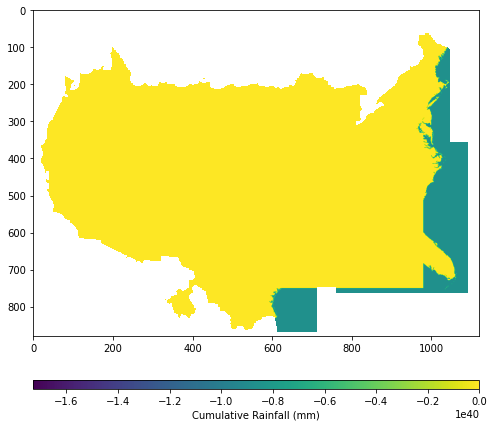

In [148]:
# Plot Map of cummulative rainfall

plt.figure(figsize=(8,8))
plt.imshow(cum_rainfall, aspect='auto')
plt.colorbar(orientation="horizontal", pad=0.1, aspect=50, label="Cumulative Rainfall (mm)")
plt.gca().axes.get_xaxis().set_visible(True)
plt.gca().axes.get_yaxis().set_visible(True)
plt.show()


In [139]:
# RAINFALL CODE ENDS

In [26]:
# Find the dimension of each pixel

height_spacing = (data.bounds.top - data.bounds.bottom)/data.height
print('height spacing: ',height_spacing,'m')

width_spacing = (data.bounds.right- data.bounds.left)/data.width
print('width spacing: ',width_spacing,'m')


height spacing:  4763.0 m
width spacing:  4763.0 m


In [27]:
data.xy(800, 550, offset ='ul') 

(714737.88926134, -7234183.69569394)

In [242]:
# Obtain basic indormation about the data

print('width:',data.width) #columns
print('height:',data.height) #rows 
print('shape:',data.shape)
print('bounds:', data.bounds) 
print('CRS:',data.crs)

# data.profile


width: 1121
height: 881
shape: (881, 1121)
bounds: BoundingBox(left=-1904912.11073866, bottom=-7619986.69569394, right=3434410.88926134, top=-3423783.69569394)
CRS: PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [230]:
# Checking the coordinates of a pixel (first pixel). x is the row, and y is the column. 
#ul, ur,ll, and lr, refers to position whether upper left (ul), upper right (ur) etc. Center is the default

data.xy(1,881, offset ='ul') 


(2291290.88926134, -3428546.69569394)

In [243]:
# Find and create a mask for the missing data values 

nodata_value = data.nodata # find the missing data 

data_masked = np.ma.masked_equal(data.read(),nodata_value) # mask the missing data 

# data_masked[1,609,800] #[1,600,800]


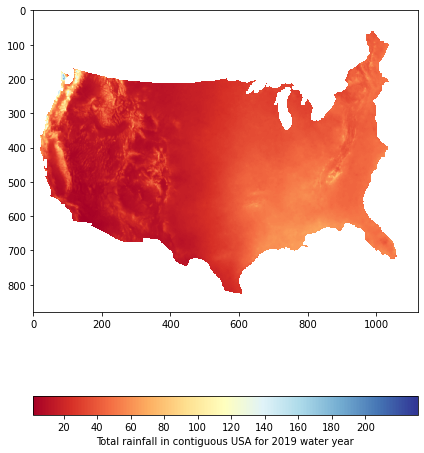

In [244]:
# Plot a map of the observed data without missing values

plt.figure(figsize= (6,8))
plt.imshow(data_masked[1,:,:], cmap = 'RdYlBu') #Band 1 contains the observed data

#plt.scatter(800, 550, marker='*', color='b', s=100) 

cb = plt.colorbar(ticks = range(0,201,20), label = 'Total rainfall in contiguous USA for 2019 water year', orientation = 'horizontal')
plt.tight_layout()
#plt.savefig('ConUS_wyr')
plt.show()
